In [1]:
import numpy as np
from numpy.random import random
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import joblib
import matplotlib.pyplot as plt


## Global Parameters



In [2]:
KERNEL = "rbf"
GLOBAL_C = 10
GAMMA = "scale"
THRESHOLD = 0.6

In [3]:
CLASS_MAPPING = {
    "cardboard": 0,
    "glass": 1,
    "metal": 2,
    "paper": 3,
    "plastic": 4,
    "trash": 5,
    "unknown": 6
}


## Load Features

In [4]:
X_train = np.load("../features/X_train_scaled.npy")
X_val = np.load("../features/X_val_scaled.npy")
X_test = np.load("../features/X_test_scaled.npy")
y_train = np.load("../features/y_train.npy")
y_val = np.load("../features/y_val.npy")
y_test = np.load("../features/y_test.npy")

In [5]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf', 'linear']
}

## Model Training

In [6]:
grid_search = GridSearchCV(
    SVC(probability=True, random_state=42),
    param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X_train, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")
print(f"Best CV score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 32 candidates, totalling 96 fits

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV score: 0.8963


## Model Evaluation

In [7]:
val_score = grid_search.score(X_val, y_val)
print(f"Validation accuracy: {val_score:.4f}")

# Train final model on train+val if validation score is good
if val_score >= 0.80:
    print("\nTraining final model on train+val...")
    X_combined = np.vstack([X_train, X_val])
    y_combined = np.concatenate([y_train, y_val])

    svm = SVC(**grid_search.best_params_, probability=True, random_state=42)
    svm.fit(X_combined, y_combined)
else:
    print("\nUsing train-only model (validation score too low)")
    svm = grid_search.best_estimator_

Validation accuracy: 1.0000

Training final model on train+val...


In [8]:
y_pred = svm.predict(X_test)
print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")



Test Accuracy: 0.9985

Classification Report:
              precision    recall  f1-score   support

   cardboard       1.00      1.00      1.00        86
       glass       1.00      0.99      1.00       137
       metal       0.99      1.00      1.00       110
       paper       1.00      1.00      1.00       159
     plastic       1.00      1.00      1.00       127
       trash       1.00      1.00      1.00        38

    accuracy                           1.00       657
   macro avg       1.00      1.00      1.00       657
weighted avg       1.00      1.00      1.00       657



## Save Model

In [9]:
# Save model
joblib.dump(svm, "../models/svm_model.pkl")
print("\nSVM model saved")


SVM model saved


## Model Prediction with Rejection

In [13]:
def svm_predict_with_rejection(model, X, threshold=0.6):
    probs = model.predict_proba(X)              # (n_samples, n_classes)
    max_probs = np.max(probs, axis=1)
    preds = np.argmax(probs, axis=1)
    class_names = model.classes_                # string labels

    final_preds = []

    for idx, conf in zip(preds, max_probs):
        if conf < threshold:
            final_preds.append(CLASS_MAPPING["unknown"])
        else:
            final_preds.append(CLASS_MAPPING[class_names[idx]])

    return np.array(final_preds), max_probs


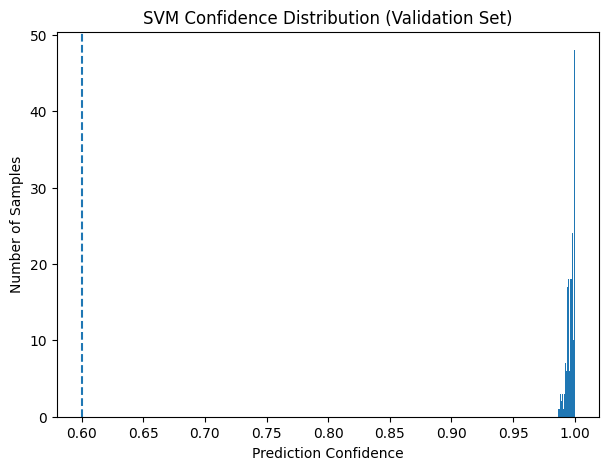

In [14]:
import matplotlib.pyplot as plt

_, svm_conf = svm_predict_with_rejection(svm, X_val, threshold=0.0)

plt.figure(figsize=(7, 5))
plt.hist(svm_conf, bins=30)
plt.axvline(0.6, linestyle='--')
plt.xlabel("Prediction Confidence")
plt.ylabel("Number of Samples")
plt.title("SVM Confidence Distribution (Validation Set)")
plt.show()
